<a href="https://colab.research.google.com/github/sankirnajoshi/intro-to-dl/blob/master/week5/POS-task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__This seminar:__ after you're done coding your own recurrent cells, it's time you learn how to train recurrent networks easily with Keras. We'll also learn some tricks on how to use keras layers and model. We also want you to note that this is a non-graded assignment, meaning you are not required to pass it for a certificate.

Enough beatin' around the bush, let's get to the task!

## Part Of Speech Tagging

<img src=https://i.stack.imgur.com/6pdIT.png width=320>

Unlike our previous experience with language modelling, this time around we learn the mapping between two different kinds of elements.

This setting is common for a range of useful problems:
* Speech Recognition - processing human voice into text
* Part Of Speech Tagging - for morphology-aware search and as an auxuliary task for most NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

Our current guest is part-of-speech tagging. As the name suggests, it's all about converting a sequence of words into a sequence of part-of-speech tags. We'll use a reduced tag set for simplicity:

### POS-tags
- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-01-06 20:37:01--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-01-06 20:37:06 (51.5 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



In [0]:
import nltk
import sys
import numpy as np
nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']
## - #EOS - End of Sentence
## - #UNK - Unknown words eg sankirna1292

data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [0]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data,test_size=0.25,random_state=42)

In [0]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    
draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [0]:
from collections import Counter
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)

all_words = ['#EOS#','#UNK#']+list(list(zip(*word_counts.most_common(20000)))[0])

#let's measure what fraction of data words are in the dictionary
print("Coverage = %.5f"%(float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values())))


Coverage = 0.96707


In [0]:
len(word_counts.keys())

49815

Coverage is the proportion of most common 10,000 words in the dataset compared to all the words in the dataset

In [0]:
from collections import defaultdict ##Supplies ids for missing values
word_to_id = defaultdict(lambda:1,{word:i for i,word in enumerate(all_words)})
tag_to_id = {tag:i for i,tag in enumerate(all_tags)}

convert words and tags into fixed-size matrix

In [0]:
def to_matrix(lines,token_to_id,max_len=None,pad=0,dtype='int32',time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines),max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix



In [0]:
batch_words,batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words,word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags,tag_to_id))

Word ids:
[[    2  3057     5     2  2238  1334  4238  2454     3     6    19    26
   1070    69     8  2088     6     3     1     3   266    65   342     2
  11533     3     2   315     1     9    87   216  3322    69  1558     4
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [   45    12     8   511  8419     6    60  3246    39     2     1 10137
      3     2   845 14205     3     1     3    10  9910     2     1  3470
      9    43 11939     1     3     6     2  1046   385    73  4562     3
      9     2 19492 18192  3250     3    12    10     2   861  5240    12
      8  8936   121 19416     4]
 [   33    64    26    12   445     7  7346     9     8  3337     3 13074
   2811     3     2   463   572     2     1     1  1649    12     1     4
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]
Ta

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [0]:
import keras
import keras.layers as L

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.SimpleRNN(64,return_sequences=True))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [0]:
from keras.utils.np_utils import to_categorical
BATCH_SIZE=32
def generate_batches(sentences,batch_size=BATCH_SIZE,max_len=None,pad=0):
    assert isinstance(sentences,np.ndarray),"Make sure sentences is a numpy array"
    
    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_words,batch_tags = [],[]
            for sent in sentences[batch_indices]:
                words,tags = zip(*sent)
                batch_words.append(words)
                batch_tags.append(tags)

            batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
            batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)

            batch_tags_1hot = to_categorical(batch_tags,len(all_tags)).reshape(batch_tags.shape+(-1,))
            yield batch_words,batch_tags_1hot
        

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [0]:
def compute_test_accuracy(model):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in test_data])
    test_words,test_tags = to_matrix(test_words,word_to_id),to_matrix(test_tags,tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n"%acc)
        sys.stdout.flush()
        

In [0]:
model.compile('adam','categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/5




1339/1343 [============================>.] - ETA: 0s - loss: 0.2734
Measuring validation accuracy...
14208/14335 [============================>.] - ETA: 0s
Validation accuracy: 0.94043

1344/1343 [==============================] - 31s - loss: 0.2726    
Epoch 2/5
1340/1343 [============================>.] - ETA: 0s - loss: 0.0585
Measuring validation accuracy...
14176/14335 [============================>.] - ETA: 0s
Validation accuracy: 0.94387

1344/1343 [==============================] - 23s - loss: 0.0585    
Epoch 3/5
1339/1343 [============================>.] - ETA: 0s - loss: 0.0518
Measuring validation accuracy...
14240/14335 [============================>.] - ETA: 0s
Validation accuracy: 0.94553

1344/1343 [==============================] - 22s - loss

Measure final accuracy on the whole test set.

In [0]:
acc = compute_test_accuracy(model)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Keras has gone on a rampage again, please contact course staff."

14335/14335 [==============================] - 3s     
Final accuracy: 0.94569


### Task I: getting all bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__. 

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN now and LSTM/GRU later) and it actually creates two layers under the hood.

Your first task is to use such a layer for our POS-tagger.

In [0]:
#Define a model that utilizes bidirectional SimpleRNN
model = keras.models.Sequential()

model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(64, return_sequences = True)))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [0]:
model.compile('adam','categorical_crossentropy')

history = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0395
Measuring validation accuracy...
14208/14335 [============================>.] - ETA: 0s
Validation accuracy: 0.94370

1344/1343 [==============================] - 23s - loss: 0.0395    
Epoch 2/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0360
Measuring validation accuracy...
14335/14335 [==============================] - 3s     

Validation accuracy: 0.94291

1344/1343 [==============================] - 23s - loss: 0.0360    
Epoch 3/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0326
Measuring validation accuracy...
14240/14335 [============================>.] - ETA: 0s
Validation accuracy: 0.94097

1344/1343 [==============================] - 23s - loss: 0.0326    
Epoch 4/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0297
Measuring validation accuracy...
14176/14335 [============================>.] - ETA: 0s
Validation accuracy: 0.94010

1344/1343 [

{'loss': [0.03950041983769933, 0.03600580630155445, 0.0325846566283856, 0.02969544301035376, 0.027093150813352118]}


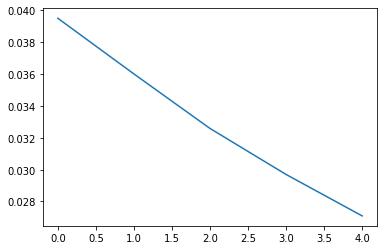

In [0]:
import matplotlib.pyplot as plt
print(history.history)
plt.plot(history.history['loss'])

In [0]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

14335/14335 [==============================] - 7s     

Final accuracy: 0.96107
Well done!


In [0]:
model.history

AttributeError: ignored

### Task II: now go and improve it

You guessed it. We're now gonna ask you to come up with a better network.

Here's a few tips:

* __Go beyond SimpleRNN__: there's `keras.layers.LSTM` and `keras.layers.GRU`
  * If you want to use a custom recurrent Cell, read [this](https://keras.io/layers/recurrent/#rnn)
  * You can also use 1D Convolutions (`keras.layers.Conv1D`). They are often as good as recurrent layers but with less overfitting.
* __Stack more layers__: if there is a common motif to this course it's about stacking layers
  * You can just add recurrent and 1dconv layers on top of one another and keras will understand it
  * Just remember that bigger networks may need more epochs to train
* __Gradient clipping__: If your training isn't as stable as you'd like, set `clipnorm` in your optimizer.
  * Which is to say, it's a good idea to watch over your loss curve at each minibatch. Try tensorboard callback or something similar.
* __Regularization__: you can apply dropouts as usuall but also in an RNN-specific way
  * `keras.layers.Dropout` works inbetween RNN layers
  * Recurrent layers also have `recurrent_dropout` parameter
* __More words!__: You can obtain greater performance by expanding your model's input dictionary from 5000 to up to every single word!
  * Just make sure your model doesn't overfit due to so many parameters.
  * Combined with regularizers or pre-trained word-vectors this could be really good cuz right now our model is blind to >5% of words.
* __The most important advice__: don't cram in everything at once!
  * If you stuff in a lot of modiffications, some of them almost inevitably gonna be detrimental and you'll never know which of them are.
  * Try to instead go in small iterations and record experiment results to guide further search.
  
There's some advanced stuff waiting at the end of the notebook.
  
Good hunting!

In [0]:
#Define a model that utilizes bidirectional SimpleRNN

model = keras.models.Sequential()

model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.LSTM(64, return_sequences = True)))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)


In [0]:
#feel free to change anything here

model.compile('adam','categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.2593
Measuring validation accuracy...
14335/14335 [==============================] - 36s    

Validation accuracy: 0.95435

1344/1343 [==============================] - 227s - loss: 0.2592   
Epoch 2/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0444
Measuring validation accuracy...
14335/14335 [==============================] - 39s    

Validation accuracy: 0.96131

1344/1343 [==============================] - 236s - loss: 0.0444   
Epoch 3/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0366
Measuring validation accuracy...
14335/14335 [==============================] - 37s    

Validation accuracy: 0.96412

1344/1343 [==============================] - 234s - loss: 0.0366   
Epoch 4/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0315
Measuring validation accuracy...
14335/14335 [==============================] - 37s    

Validation accuracy: 0.96529

1344/134

In [0]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

if acc >= 0.99:
    print("Awesome! Sky was the limit and yet you scored even higher!")
elif acc >= 0.98:
    print("Excellent! Whatever dark magic you used, it certainly did it's trick.")
elif acc >= 0.97:
    print("Well done! If this was a graded assignment, you would have gotten a 100% score.")
elif acc > 0.96:
    print("Just a few more iterations!")
else:
    print("There seems to be something broken in the model. Unless you know what you're doing, try taking bidirectional RNN and adding one enhancement at a time to see where's the problem.")

14335/14335 [==============================] - 35s    

Final accuracy: 0.96544
Just a few more iterations!


In [0]:
## With 2 layer Bi-directional LSTM

model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.LSTM(64, return_sequences = True,   recurrent_dropout=0.2)))
model.add(L.Bidirectional(L.LSTM(128, return_sequences = True,   recurrent_dropout=0.2)))
model.add(L.Bidirectional(L.LSTM(256, return_sequences = True,   recurrent_dropout=0.2)))
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)


In [0]:
#feel free to change anything here
from keras.callbacks import EarlyStopping

model.compile('adam','categorical_crossentropy')

earlyStop=EarlyStopping(monitor="loss",verbose=2,mode='min',patience=3)

history = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy(),earlyStop], epochs=10,)

Epoch 1/10
1343/1343 [============================>.] - ETA: 0s - loss: 0.0411
Measuring validation accuracy...
14335/14335 [==============================] - 96s    

Validation accuracy: 0.96827

1344/1343 [==============================] - 594s - loss: 0.0411   
Epoch 2/10
1343/1343 [============================>.] - ETA: 0s - loss: 0.0317
Measuring validation accuracy...
14335/14335 [==============================] - 101s   

Validation accuracy: 0.97104

1344/1343 [==============================] - 612s - loss: 0.0317   
Epoch 3/10
1343/1343 [============================>.] - ETA: 0s - loss: 0.0270
Measuring validation accuracy...
14335/14335 [==============================] - 96s    

Validation accuracy: 0.97269

1344/1343 [==============================] - 607s - loss: 0.0270   
Epoch 4/10
1343/1343 [============================>.] - ETA: 0s - loss: 0.0230
Measuring validation accuracy...
14335/14335 [==============================] - 96s    

Validation accuracy: 0.97285

1344

```

```

```

```

```

```

```

```

```

```

```

```


#### Some advanced stuff
Here there are a few more tips on how to improve training that are a bit trickier to impliment. We strongly suggest that you try them _after_ you've got a good initial model.
* __Use pre-trained embeddings__: you can use pre-trained weights from [there](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) to kickstart your Embedding layer.
  * Embedding layer has a matrix W (layer.W) which contains word embeddings for each word in the dictionary. You can just overwrite them with tf.assign.
  * When using pre-trained embeddings, pay attention to the fact that model's dictionary is different from your own.
  * You may want to switch trainable=False for embedding layer in first few epochs as in regular fine-tuning.  
* __More efficient batching__: right now TF spends a lot of time iterating over "0"s
  * This happens because batch is always padded to the length of a longest sentence
  * You can speed things up by pre-generating batches of similar lengths and feeding it with randomly chosen pre-generated batch.
  * This technically breaks the i.i.d. assumption, but it works unless you come up with some insane rnn architectures.
* __Structured loss functions__: since we're tagging the whole sequence at once, we might as well train our network to do so.
  * There's more than one way to do so, but we'd recommend starting with [Conditional Random Fields](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/)
  * You could plug CRF as a loss function and still train by backprop. There's even some neat tensorflow [implementation](https://www.tensorflow.org/api_guides/python/contrib.crf) for you.
